# H&alpha; Emitter Luminosity Function

In this example, we attempt to reproduce the Schechter model for H&alpha; emitter luminosity function accounting for luminosity and density evolution&mdash;this is Model 1 in Pozzetti et al. 2016 ([arXiv:1603.01453](https://arxiv.org/abs/1603.01453)).

In [1]:
from pprint import pformat
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy.cosmology import Planck15
from mpl_toolkits import mplot3d

from conf import PATHEXT
from horizonground.lumfunc_modeller import LumFuncModeller, alpha_emitter_schechter_lumfunc

First we define for the luminosity function parameter ranges under consideration: log-10 luminosity $\lg{L}$, redshift $z$ and lumonisty function value $\Phi(\lg{L}, z)$.

In [2]:
LOG10_LUMINOSITY_RANGE = 38.8, 43.8
REDSHIFT_RANGE = 0.25, 3.
DENSITY_RANGE = pow(10, -5.9), pow(10, -1.1)

##  H&alpha; luminosity function model

We employ *LumFuncModeller* to model the H&alpha; emitter luminosity function with the best-fit parameters loaded from a text file, and set relevant model options.

In [3]:
modeller = LumFuncModeller.from_parameter_file(
    parameter_file=PATHEXT/"H-alpha_LF_Schechter_model_fits.txt",
    model_lumfunc=alpha_emitter_schechter_lumfunc,
    brightness_variable='luminosity',
    threshold_value=3.e-16,
    cosmology=Planck15
)

luminosity_function_model = modeller.luminosity_function

The luminosity function can be visualised as a surface over $(\lg{L}, z)$ coordinates.

Text(0.5, 0, '$\\Phi(\\lg{L},z)$ [$\\mathrm{Mpc}^{-3}$/dex]')

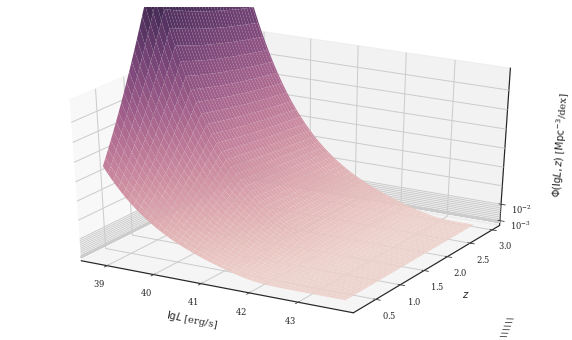

In [4]:
NUM_MESH = 100

luminosities = np.linspace(*LOG10_LUMINOSITY_RANGE, num=NUM_MESH, endpoint=False)
redshifts = np.linspace(*REDSHIFT_RANGE, num=NUM_MESH, endpoint=False)

lgL_grid, z_grid = np.meshgrid(luminosities, redshifts)
Phi_grid = luminosity_function_model(lgL_grid, z_grid)

fig = plt.figure("Luminosity function surface", figsize=(10, 6))
ax = plt.axes(projection='3d')

ax.plot_surface(lgL_grid, z_grid, Phi_grid, cmap=sns.cubehelix_palette(as_cmap=True), edgecolor='none')

ax.tick_params(axis='both')
ax.set_xlabel(r"$\lg{L}$ [erg/s]", labelpad=10)
ax.set_ylabel(r"$z$", labelpad=10)

ax.set_zscale('log')
ax.set_zlim(*DENSITY_RANGE)
ax.set_zticks([pow(10, -2), pow(10, -3)])
ax.set_zlabel(r"$\Phi(\lg{L},z)$ [$\mathrm{Mpc}^{-3}$/dex]", labelpad=10)

## H&alpha; luminosity function results

We now plot the best-fit luminosity model sampled at the following luminosity values in the following redshift bins.

In [5]:
NUM_LUM_INTERVALS = 100

lgL = np.linspace(*LOG10_LUMINOSITY_RANGE, num=NUM_LUM_INTERVALS+1)

redshift_bin_edges = np.array([0., 0.3, 0.6, 0.9, 1.3, 1.7, 2.3])
redshift_bins = OrderedDict(zip(
    map(lambda ends: r"${} < z < {}$".format(*ends), zip(redshift_bin_edges[:-1], redshift_bin_edges[1:])),
    (redshift_bin_edges[:-1] + redshift_bin_edges[1:])/2
))

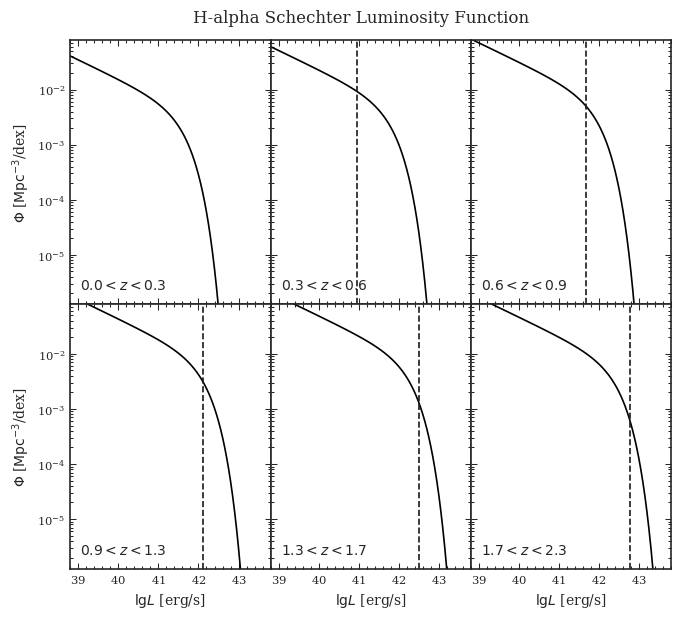

In [6]:
NUM_ROW, NUM_COL = 2, 3
ROW_SPAN, COL_SPAN = 4, 4

fig = plt.figure(figsize=(7.75, 7.))

for bin_idx, (bin_label, z) in enumerate(redshift_bins.items()):
    # Set up the canvas grid.
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, colspan=COL_SPAN
    )
    
    # Plot with different options depending on the subplot.
    ax.plot(lgL, luminosity_function_model(lgL, z))
    ax.axvline(modeller.brightness_threshold(redshift_bin_edges[bin_idx]), c='k', ls='--')
    
    # Set axis ticks and labels.
    ax.set_xscale('linear')
    ax.set_xlim(*LOG10_LUMINOSITY_RANGE)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        ax.tick_params(axis='x', which='both', direction='in', labelbottom=False, labelsize=2)
    else:
        ax.set_xlabel(r"$\lg{L}$ [erg/s]")
        
    ax.set_yscale('log')    
    ax.set_ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        ax.tick_params(axis='y', which='both', direction='in', labelleft=False, labelsize=2)
    else:
        ax.set_ylabel(r"$\Phi$ [$\mathrm{Mpc}^{-3}$/dex]")
    
    ax.set_title(bin_label, loc='left', position=(0.05, 0.025))

fig.suptitle("H-alpha Schechter Luminosity Function", verticalalignment='bottom', y=0.9)
fig.set_dpi(100)